> **University of Pisa** \
> **M.Sc Computer Science, Artificial Intelligence** \
> **Data Mining 2022/23** \
> **Authors** \
* Irene Pisani - i.pisani1@studenti.unipi.it - 560104 
* Andrea Iommi - a.iommi2@studenti.unipi.it  - 578212

---
This notebook presents an explorative analysis of the ***users.csv*** and ***tweets.csv*** datasets. In order to know more details about what we have done, we suggest to read te report.

#### Dataset used
1. *users.csv* dataset describes users **general information**.

2. *tweets.csv* reports information about the **single tweet**.

#### Tasks

1. Data Understanding and Preparation
2. Clustering Analysis
3. Predictive Analysis (Classification Genuine/Bot)
4. **Time series Analysis**

In [ ]:
%%capture
!pip install tslearn pyts

In [ ]:
#@title  Libraries

import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.stats as st
import seaborn as sn

from pandas import DataFrame
from tqdm import tqdm
from scipy.spatial.distance import pdist,squareform

from tslearn.clustering import TimeSeriesKMeans 
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import ShapeletModel
from tslearn.preprocessing import TimeSeriesResampler

from pyts.classification import LearningShapelets as py_LearningShapelets

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from yellowbrick.cluster import KElbowVisualizer

from google.colab import drive

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

drive.mount('/content/drive')

Mounted at /content/drive


# Task4: Time series Analisys

## Loading the dataset

In [ ]:
tweets = pd.read_csv("/content/drive/MyDrive/DataMining/tweets2class_and_ts.csv", 
                     usecols=["user_id","retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions","created_at"])

users = pd.read_csv("/content/drive/MyDrive/DataMining/users2class_and_ts.csv",index_col=0,usecols=["user_id","real"])

We select only tweets published in 2019

In [ ]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['created_at'] = pd.to_datetime(tweets['created_at'].dt.date)
tweets.drop(tweets[tweets.created_at.dt.year != 2019].index,inplace=True)

In [ ]:
#@title  Utils functions

def split_in_weeks(seq:list, num_of_weeks=52): # There are 52 weeks in 2019.
  # This function split in weeks the time series 
  avg = len(seq) / float(num_of_weeks)
  out,last = [], 0.0
  while last < len(seq):
      s = seq[int(last):int(last + avg)]
      out.append(np.mean(s))
      last += avg
  return out
    
def normalization(type_norm="std"):
  # This is a higher order function, it returns a Standard scaler by default
  # else return a MinMax scaler
  if type_norm == "std":
    return lambda ts : (ts - ts.mean()) / ts.std()
  elif type_norm == "minmax":
    return lambda ts : (ts - ts.min()) / (ts.max() - ts.min())

def sigma_rule(column:int,gain:int):
  mean, std = column.mean(), column.std() # mean and standard deviation 
  left  = mean - gain * std
  right = mean + gain * std
  return column[(column > left) & (column < right)],(left,right)  

def remove_outliers(dt:DataFrame,sigma:int)->DataFrame:
  outliers = pd.DataFrame(columns=dt.columns)

  for col in dt.columns:
    _,(left,right) = sigma_rule(dt[col],sigma)
    outliers = outliers.append(dt[(dt[col] > right) | (dt[col] < left)])

  outliers.drop_duplicates(inplace=True)
  print("Data discarded",round( len(outliers)/len(dt),3) * 100,"%")
  return outliers

def plot_cluster_ts(n_cluster,df_and_models,metrics=["Euclidean","Dynamic Time Wrapping"]):
  f, axs = plt.subplots(nrows = n_cluster, ncols = 2, figsize=(25,8))
  f.tight_layout(pad=2)

  for cl in range(0,n_cluster):
    for idx,(df,model) in enumerate(df_and_models):

      clust = df[df["labels"]==cl][[*range(1,47)]+["real"]]
      for j in range(len(clust)): # plotting each TS divided by color 
        color = "blue" if clust.iloc[j,-1] == True else "green"
        axs[cl][idx].plot(clust.iloc[j,:-1],alpha=0.01,color=color)  

      axs[cl][idx].set_xlim(0.5,46.5)
      axs[cl][idx].locator_params(axis='x', nbins=52)
      axs[cl][idx].plot([*range(1,47)],model.cluster_centers_[cl], linewidth = 2.5,color="red",label="Cluster "+str(cl))
      axs[cl][idx].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.3)
      axs[cl][idx].set_xlabel("Weeks in 2019")
      axs[cl][idx].set_ylabel("Normalized Success score")
      axs[cl][idx].set_title("Clustering of Time Series using the "+ metrics[idx] +" distance")

      # Segment for weeks
      axs[cl][idx].axvline(x = 1 ,color  = 'purple', linewidth = 0.5, linestyle ='-.')
      for k in range(1,14):
        axs[cl][idx].axvline(x = (k*4.333) ,color  = 'purple', linewidth = 0.5, linestyle ='-.')
      axs[cl][idx].legend()     

  plt.show()

def plot_histograms(n_cluster,df_and_models):
  f, axs = plt.subplots(ncols = 2, figsize=(12,5))
  f.tight_layout(pad=4)

  etiquettes = ["Clust "+ str(i) for i in range(n_cluster)]
  for idx,(df,_) in enumerate(df_and_models):

    reals = [len(df[(df["labels"] == i) & (df.real == True)]) for i in range(n_cluster)]
    bots  = [len(df[(df["labels"] == i) & (df.real == False)]) for i in range(n_cluster)]
    X_axis = np.arange(n_cluster)
    axs[idx].bar(X_axis - 0.2, reals, 0.4, label = 'Real users')
    axs[idx].bar(X_axis + 0.2, bots, 0.4, label = 'Bot users')
    axs[idx].set_xticks(X_axis) # values
    axs[idx].set_xticklabels(etiquettes) # labels
    axs[idx].set_title("Number of users into clusters")
    axs[idx].set_xlabel("Clusters")
    axs[idx].set_ylabel("Number of elements in the cluster")
    axs[idx].legend()
    axs[idx].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)  
    for p in axs[idx].patches: 
        axs[idx].annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2, p.get_height()))

  plt.show() 

### Time series generator

We took all tweets in 2019 and we grouped they by users. For each user we created a time series a year long. Each value of TS (which corresponding a certain day) is performed by **success score**.

\begin{align}
  Score = \frac{Acceptance}{(Diffusion + 0.1)}
\end{align}

\begin{align}
  Acceptance = retweet\_count + reply\_count + favorite\_count
\end{align}
\begin{align}
  Diffusion = num\_hashtags + num\_urls + num\_mentions
\end{align}
  
The Acceptance is considered to understand how much the social network enjoys
the shared content while the Diffusion describes the effort put on promoting the tweet by the content creator.

If there are not tweets in a particular day, the default values is -1

In [ ]:
list_of_ts =  []

unique_users = tweets.user_id.unique()
range_of_dates = pd.date_range(start="1/1/2019",periods=365) 
all_datas = pd.DataFrame(range_of_dates,columns=["created_at"])

used_columns = ["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions"]
acceptance_cols = ["retweet_count","reply_count","favorite_count"]
diffusion_cols = ["num_hashtags","num_urls","num_mentions"]

for user_id in tqdm(unique_users,total=len(unique_users)): # for each user, create a time series

  user = tweets[tweets.user_id == user_id][tweets.columns[1:]]
  user_grupped = user.groupby(["created_at"]).sum()
  acceptance = user_grupped[acceptance_cols].sum(axis=1) # Acceptance score
  diffusion = user_grupped[diffusion_cols].sum(axis=1) # Diffusion score

  score = pd.DataFrame(acceptance / (diffusion + 0.1),columns=["Score"])
  score = score.merge(all_datas,on="created_at",how="right").fillna("-1").set_index(["created_at"]).astype(int)
  # On top of the list, we append the user_id, in order to associate a Ts to user
  list_of_ts.append([user_id]  + score.Score.values.tolist())

100%|██████████| 6787/6787 [02:18<00:00, 49.09it/s]


## Segmentation



We chose to divide the TS into **weeks** for the clustering task. First of all because it's interesting  to study a general behavior of TS and fine granularity is not much informative. In addiction the segmentation allows the clustering techniques to work well (dimensional reduction). For the classification through the shapelets, instead, we used both "type" of TS. So we have a set of TS that contains roughly 365 days and a set of TS with 52 weeks.

In [ ]:
# The first element represent a user_id, then there are 52 values, each values representing a weeks
users_ts = [[ts[0]] +  split_in_weeks(ts[1:]) for ts in list_of_ts] # list of list
users_ts = pd.DataFrame(users_ts, columns=["id_user"] + [*range(1,53)] ).set_index("id_user")

*Visualizing all time series we have noticed that there is no activity in the last 6 weeks, so we delete them.*

In [ ]:
users_ts.drop([47,48,49,50,51,52], axis=1, inplace=True)

For the full TS we removed the noise applying a moving average with a slide window equal to 4.

In [ ]:
users_ts_full = pd.DataFrame(list_of_ts, columns=["id_user"] + [*range(1,366)] ).set_index("id_user")
# Again, we remove all days which no have activity
users_ts_full.drop(columns=users_ts_full.columns[319:], axis=1, inplace=True)


users_std_ts_full = users_ts_full.apply(normalization(),axis=1)
users_std_ts_full = users_std_ts_full.rolling(4,axis=1).mean().dropna(axis=1) # We apply a Moving average to reduce the noise
users_std_ts_full["real"] = users[users.index.isin(users_ts.index)]["real"]

users_minmax_ts_full = users_ts_full.apply(normalization("minmax"),axis=1)
users_minmax_ts_full = users_minmax_ts_full.rolling(4,axis=1).mean().dropna(axis=1) # We apply a Moving average to reduce the noise
users_minmax_ts_full["real"] = users[users.index.isin(users_ts.index)]["real"]

## Clustering (K-Means)

In this phase we applied a K-means clustering tecnique using a different normalization methods and different metrics.

### K-Means with the Z-score

#### Removing the outliers
After different tries, we discovered that there are no extreme values to remove by sigma rule

In [ ]:
users_std_ts = users_ts.apply(normalization(),axis=1)
# outliers = remove_outliers(users_std_ts,200)
# users_std_ts.drop(outliers.index,inplace=True)

In [ ]:
n_cluster = 3

In [ ]:
# KMeans of time series applied with the euclidean metric and z-score standardization
model_zscore_eucl = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=100, random_state=42)
labels_zscore_eucl = model_zscore_eucl.fit_predict(users_std_ts.iloc[:,:46])

# KMeans of time series applied with the dynamic time wrapping metric and z-score standardization
model_zscore_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", max_iter=5, random_state=42)
labels_zscore_dtw = model_zscore_dtw.fit_predict(users_std_ts.iloc[:,:46])

users_std_ts["real"] = users[users.index.isin(users_ts.index)]["real"]

users_std_ts_eucl = users_std_ts.copy()
users_std_ts_dtw = users_std_ts.copy()

users_std_ts_eucl["labels"] = labels_zscore_eucl
users_std_ts_dtw["labels"] = labels_zscore_dtw

#### Apply Kmeans

We have tried a lot of configuration and we think that 3 in a optimal parameter

#### **Interpretability**

The charts show all TS associate to a particular cluster. Each TS is composed of 46 points (each value corresponding to mean of week' success score). The color defines if the TS belongs a real or bot user.(Blue = real user, Green = Bot). The red line identifies a centroid of the cluster. There is also, a purple line which corresponding roughly to one month. We have two types of result: on the left it was applied the K-means with the Euclidean distance, on the right with the Dynamical Time Wrapping.

Intertia euclidean:  24.773
Intertia dtw:  6.858


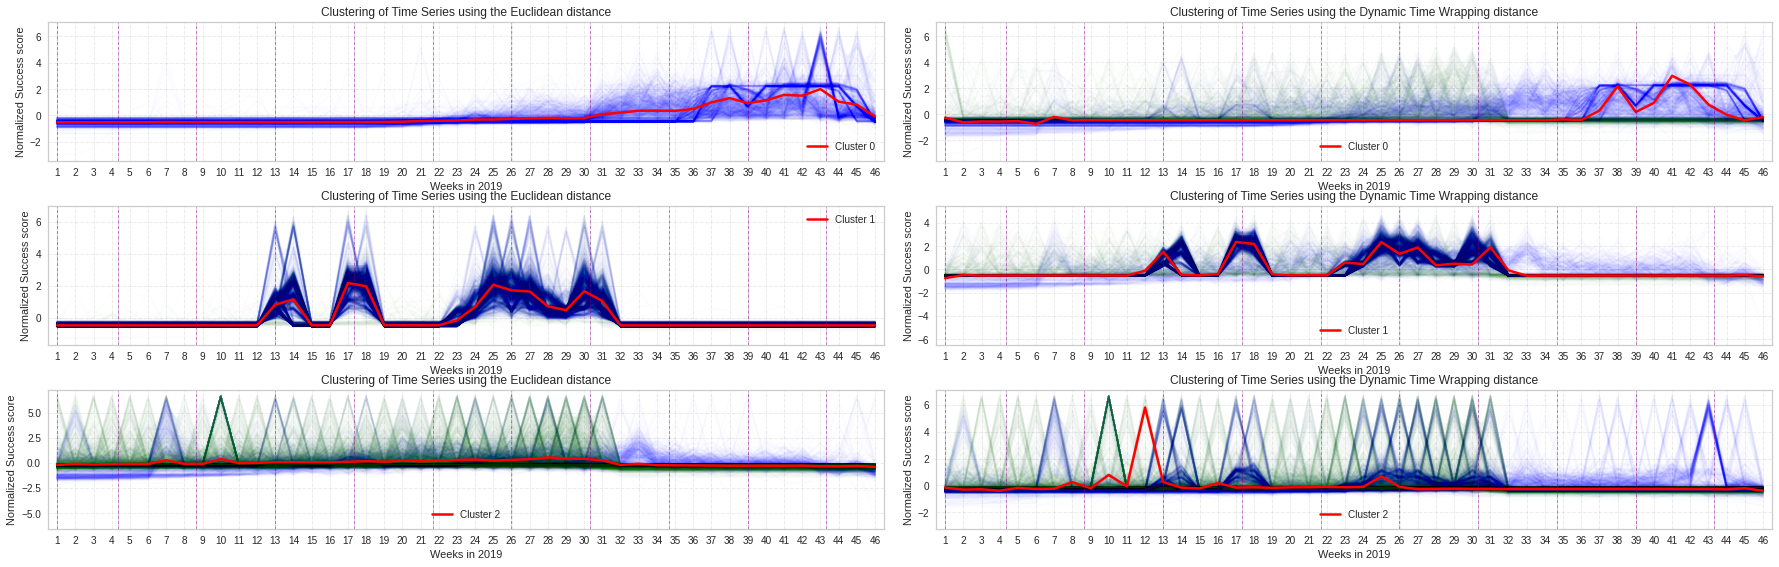

In [ ]:
print("Intertia euclidean: ",round(model_zscore_eucl.inertia_,3))
print("Intertia dtw: ",round(model_zscore_dtw.inertia_,3))

params = [(users_std_ts_eucl,model_zscore_eucl),(users_std_ts_dtw,model_zscore_dtw)]
plot_cluster_ts(n_cluster,params)

#### **Results:**

Concerning to ***Euclidean distance*** we have:

**Cluster 0,** basically, is populated by a real user. In this first group we have major activity approximately from *September to November* and very low activity in the rest of the year. The most relevant tweets have been published in *October*. This cluster has captured the users that have published relevant tweets during the *autumn-winter seasons*. In **Cluster 1**, there is a mix of real and bot users, even if there is a predominance of real users. Different from the previous chart, the cluster covers the *spring-summer seasons*. This time we have no constancy, in fact, we can notice that there is a short period with low or null activity, this means that any of users have published relevant tweets. In this last group,  **Cluster 2**, we have a bot predominance. Different from the previous charts we have no correlation with the seasons because there are some "spikes" that lays on all weeks. The major activity is given for the first half of the year. The bot users have the particularity of having the patterns repeating.

Regarding to ***Dynamic time wrapping*** distance, more or less we obtained the same result.

However we can summarize the differences in :

1. DTW has **low interita** than Euclidean this means the quality of the clustering is better.
2. The Euclidean distance perform result **cleaner than DTW**, we can see there there are more noise in the DTW.
3. Euclidean distance was able to **separate better** the bot and real users that DTW

#### **Conclusion**

* The algorithm found tree different kind of behavior.
* The main difference is given from the activity during the seasons.
* The cluster 0 and 1 (in the euclidean distance) has captured the behavior of real and bot user.
* All users have not published tweets after 46-th weeks


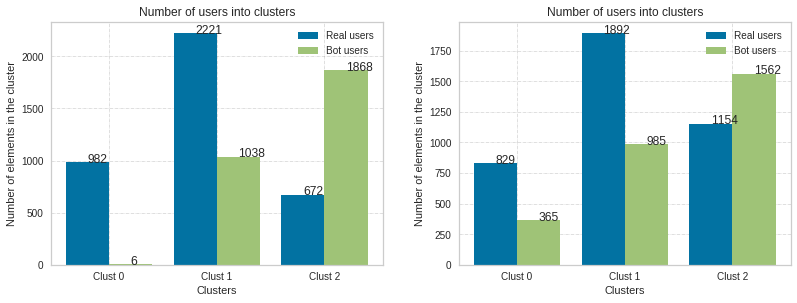

In [ ]:
plot_histograms(n_cluster,params)

### Kmeans with MinMax

#### Remove outliers

In [ ]:
users_minmax_ts = users_ts.apply(normalization("minmax"),axis=1)
# outliers = remove_outliers(users_minmax_ts,7.8)
# users_minmax_ts.drop(outliers.index,inplace=True)

In [ ]:
model_minmax_eucl = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=100, random_state=42)
labels_minmax_eucl = model_minmax_eucl.fit_predict(users_minmax_ts.iloc[:,:46])

model_minmax_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", max_iter=5, random_state=42)
labels_minmax_dtw = model_minmax_dtw.fit_predict(users_minmax_ts.iloc[:,:46])

users_minmax_ts["real"] = users[users.index.isin(users_ts.index)]["real"]

users_minmax_ts_eucl = users_minmax_ts.copy()
users_minmax_ts_dtw = users_minmax_ts.copy()

users_minmax_ts_eucl["labels"] = labels_minmax_eucl
users_minmax_ts_dtw["labels"] = labels_minmax_dtw

#### Apply Kmeans

Intertia euclidean:  1.692
Intertia dtw:  0.399


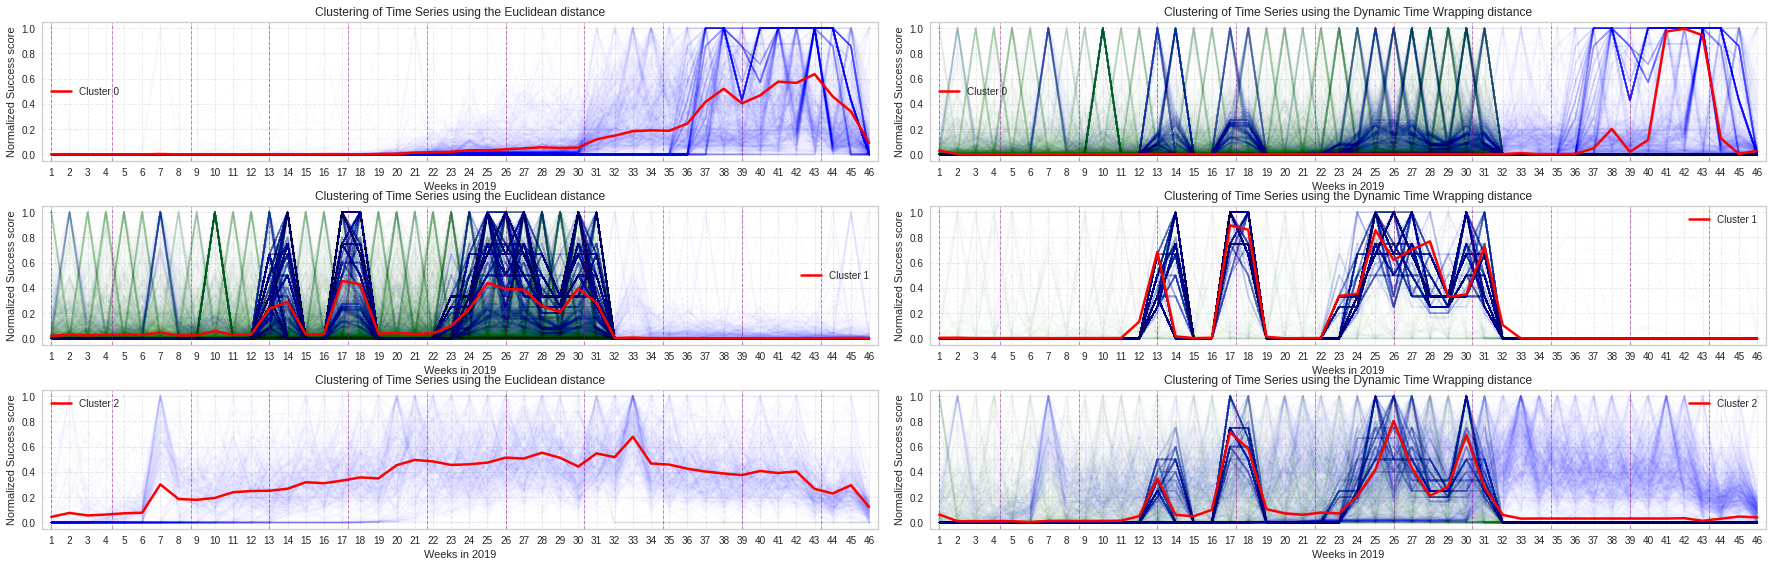

In [ ]:
print("Intertia euclidean: ",round(model_minmax_eucl.inertia_,3))
print("Intertia dtw: ",round(model_minmax_dtw.inertia_,3))

params = [(users_minmax_ts_eucl,model_minmax_eucl),(users_minmax_ts_dtw,model_minmax_dtw)]
plot_cluster_ts(n_cluster,params)

The result is almost the same, however with the *minmax* normalization the seasonality behavior is no more evident as in *Z-score*. Concerning to intertia also in this way the DTW produced better cluster but it was not able to divide well the real and bot users.

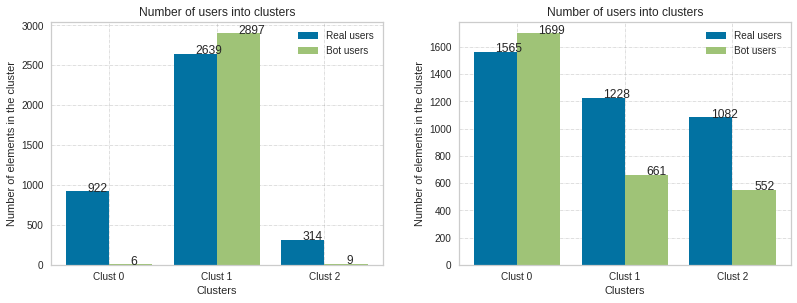

In [ ]:
plot_histograms(n_cluster,params)

## Classification (Shapelet)

In this phase we learned the shapelet, defined as “*subsequences that are in some sense maximally representative of a class*”. Informally, if we assume a binary classification setting, a shapelet is discriminant if it is present in most series of one class and absent from series of the other class. We tried several configurations (algorithm, normalization and nature of TS).

*(Enumerated configurations)*

**LearningShapelet provided by tslearn**
1.   (A) weekly TSwith Z-score
2.   (B) weekly TS with MinMax
3.   (C) full TS with Z-score
4.   (D) full TS with MinMax

**LearningShapelet provided by  pyts**
1.   (E) weekly TS with Z-score
2.   (F) weekly TS with MinMax


### LearningShapelet provided by [tslearn](https://tslearn.readthedocs.io/en/stable/gen_modules/shapelets/tslearn.shapelets.LearningShapelets.html#tslearn.shapelets.LearningShapelets)

We tried some configurations using the classic grid search. The dataset was split into Training (80%) and Test(20%) after applied the shuffling. Some parameters as *Learning rate* or *batch_size* are fixed to reduce the number tests.

In [ ]:
#@title Grid search implementation 1

from tslearn.shapelets import LearningShapelets as LearningShapeletsA
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

class GridSearchA:

  def __init__(self, df:DataFrame,ts_len=46):

    self.length = int(len(df)*.8) # 80% Train 20% Validation
    
    df = df.sample(frac=1,random_state=78) 

    # Fist 46 columns are the inputs, the last one is the target (1 = Real, 0 = Bot)
    train_x = df.iloc[:self.length,:-1]
    train_y = df.iloc[:self.length,-1].astype(int)

    test_x  = df.iloc[self.length:,:-1]
    test_y  = df.iloc[self.length:,-1].astype(int)

    self.train_x = train_x.values.reshape(-1,ts_len,1)
    self.train_y = train_y.values

    self.test_x  = test_x.values.reshape(-1,ts_len,1)
    self.test_y  = test_y.values

    # Number of time series (total users) , (TS length = 46 weeks)
    self.num_ts, self.ts_sz = self.train_x.shape[0], self.train_x.shape[1]
  
  def perform_configurations(self, lenght_shap:list, n_shapelet:list, epochs:list):
    print("Epochs;Length.Shapelet;N.Shapelet;Score")
    # Try all combinations
    for e in epochs:
      for l in lenght_shap:
        for r in n_shapelet:
          try:
            result = self.classification(l,r,e)
          except:
            result = "error"
          print(e,";",l,";",r,";",result)
    return 

  def classification(self, l:float, r:float, e:int) -> float:
    
    optim = tf.optimizers.Adagrad(learning_rate=0.2) # fixed LR

    # Compute number and length of shapelets, I also tried diffent configuration
    shp_size = grabocka_params_to_shapelet_size_dict(n_ts=self.num_ts, ts_sz=self.ts_sz,  n_classes=2, l=l, r=r)

    shp_clf = LearningShapeletsA(n_shapelets_per_size=shp_size,optimizer=optim, weight_regularizer=.01,
                                max_iter=e,random_state=87,scale=False,verbose=1).fit(self.train_x, self.train_y)
    
    return accuracy_score(self.test_y, shp_clf.predict(self.test_x)) 

  def perform_best(self, l:float, r:float, e:int):

    optim = tf.optimizers.Adagrad(learning_rate=0.2) # fixed LR

    # Compute number and length of shapelets, I also tried diffent configuration
    shp_size = grabocka_params_to_shapelet_size_dict(n_ts=self.num_ts, ts_sz=self.ts_sz,  n_classes=2, l=l, r=r)

    shp_clf = LearningShapeletsA(n_shapelets_per_size=shp_size,optimizer=optim, weight_regularizer=.01,
                                max_iter=e,random_state=87,scale=False,verbose=0).fit(self.train_x, self.train_y)
    
    print(accuracy_score(self.test_y, shp_clf.predict(self.test_x)))

    return shp_size,shp_clf

Configurations

In [ ]:
length_shapelet = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
n_shapelet = [1, 2, 3, 4, 5]
n_epochs = [50, 100, 200, 600]

In [ ]:
# Be careful, it requires al lot of time to execute all configuration!! (more or less 2h)
# GridSearchA(users_std_ts).perform_configurations(length_shapelet,n_shapelet,n_epochs)
# GridSearchA(users_minmax_ts).perform_configurations(length_shapelet,n_shapelet,n_epochs)

In [ ]:
# Be careful, it requires al lot of time to execute all configuration!! (more or less 6h)
# GridSearchA(users_std_ts_full,316).perform_configurations(length_shapelet,n_shapelet,n_epochs)
# GridSearchA(users_minmax_ts_full,316).perform_configurations(length_shapelet,n_shapelet,n_epochs)

**Results of A & B** (short TS)

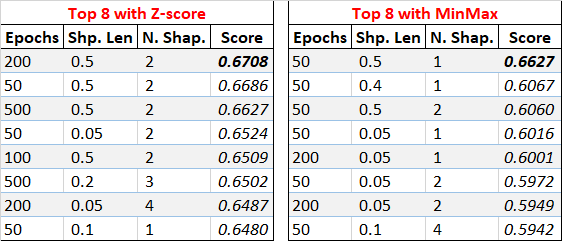

**Results of C & D** (full TS)

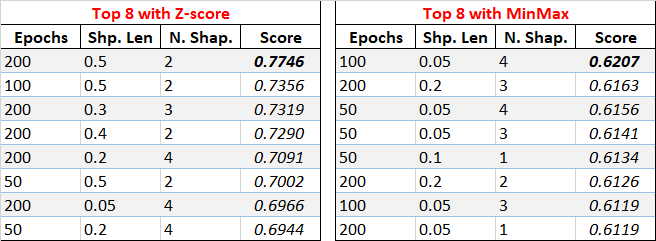

#### **Considerations**

The best score achieved is equal to **0.7746** (table C), we can point out basically two things: the first one is that for this kind of task the z-score perform better respect to minmax indeed we can see that the score achieved in z-score are higher respect others normalization. The second is that the best parameters for short and full TS are exactly the same, but a full time series is more suitable for this classification task. 

Concerning the values of parameters we can notice that the higher scores are associated to mainly to a few and long shapelts with the low number of epochs.

### LearningShapelet provided by [pyts](https://pyts.readthedocs.io/en/stable/generated/pyts.classification.LearningShapelets.html#pyts.classification.LearningShapelets)

We apply the same mechanism of prevoius grid seach.

In [ ]:
#@title Grid search implementation 2

from pyts.classification import LearningShapelets as LearningShapeletsB
class GridSearchB:

  def __init__(self, df:DataFrame,ts_len=46):

    self.length = int(len(df)*.8) # 80% Train 20% Validation

    df = df.sample(frac=1,random_state=78) 

    # Fist 46 columns are the inputs, the last one is the target (1 = Real, 0 = Bot)
    train_x = df.iloc[:self.length,:-1]
    train_y = df.iloc[:self.length,-1].astype(int)

    test_x  = df.iloc[self.length:,:-1]
    test_y  = df.iloc[self.length:,-1].astype(int)

    self.train_x = train_x.values.reshape(-1,ts_len)
    self.train_y = train_y.values

    self.test_x  = test_x.values.reshape(-1,ts_len)
    self.test_y  = test_y.values

    self.num_ts, self.ts_sz = self.train_x.shape[0], self.train_x.shape[1]
  
  def perform_configurations(self, lenght_shap:list, n_shapelet:list, epochs:list):
    print("Epochs;Length.Shapelet;N.Shapelet;Score")
    for e in epochs:
      for l in lenght_shap:
        for r in n_shapelet:
          try:
            result = self.classification(l,r,e)
          except:
            result = "error"
          print(e,";",l,";",r,";",result)
    return 

  def classification(self, l:float, r:float, e:int) -> float:
    
    shp_clf = LearningShapeletsB(n_shapelets_per_size=r,max_iter=e,min_shapelet_length=l,
                                learning_rate=3,tol=0.002,verbose=1,random_state=78).fit(self.train_x, self.train_y)
    
    return shp_clf.score(self.test_x,self.test_y)

Configurations

In [ ]:
length_shapelet = [0.05, 0.1, 0.2, 0.3]
n_shapelet = [0.1, 0.2, 0.3]
n_epochs = [50, 100, 200, 500]

In [ ]:
# Be careful, it requires al lot of time to execute all configuration!! (more or less 4h)
# GridSearchB(users_std_ts).perform_configurations(length_shapelet,n_shapelet,n_epochs)
# GridSearchB(users_minmax_ts).perform_configurations(length_shapelet,n_shapelet,n_epochs)

**Results of E & F**

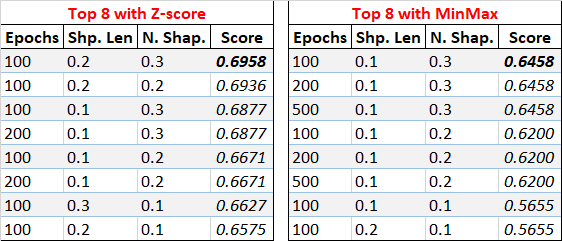

#### **Considerations**
We tried to learn the shaplet also with a different library. Since this library is very slower respect to the previous one, the number of configurations tried was bounded. In any case the result achieved is more or less the same, in fact as said in the previous grid search, the z-score reach better result respect to minmax.

### **Analysing result obtained**
After discovered the best configurations, we analized the shaplets obtained.


In [ ]:
# more or less 7m to execute
shp_size, shp_clf = GridSearchA(users_std_ts_full,316).perform_best(0.5,2,200) 

0.7746686303387335


#### **Dictionary**

We obtained 8 shapelets, 5 are length equal to 158, 3 are length equalt 316 (max length of TS)

In [ ]:
shp_size

{158: 5, 316: 3}

#### **Training loss**

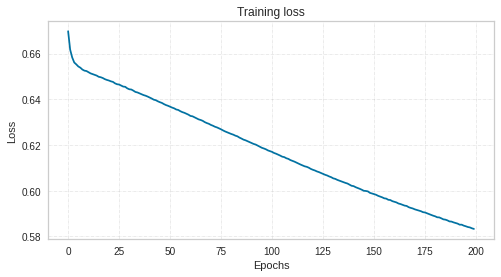

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.3)
plt.plot(shp_clf.history_["loss"])
plt.show()

#### **Confidence of classification**

In [ ]:
DataFrame(shp_clf.predict_proba(users_std_ts_full.iloc[:,:-1]),
          index=users_std_ts_full.iloc[:,:-1].iloc[:,:-1].index,
          columns=["Bot","Real"]).sort_values(by="Real")

,Bot,Real
id_user,,
93941188,0.945825,0.054175
205030249,0.930137,0.069863
156751025,0.929132,0.070868
67044273,0.923616,0.076384
335821350,0.900029,0.099971
...,...,...
1372026204,0.040461,0.959539
334826952,0.038288,0.961712
282659109,0.035278,0.964722


#### **Shapelet learned**

In [ ]:
predicted_locations = DataFrame(shp_clf.locate(users_std_ts_full.iloc[:,:-1]),index=users_std_ts_full.index)

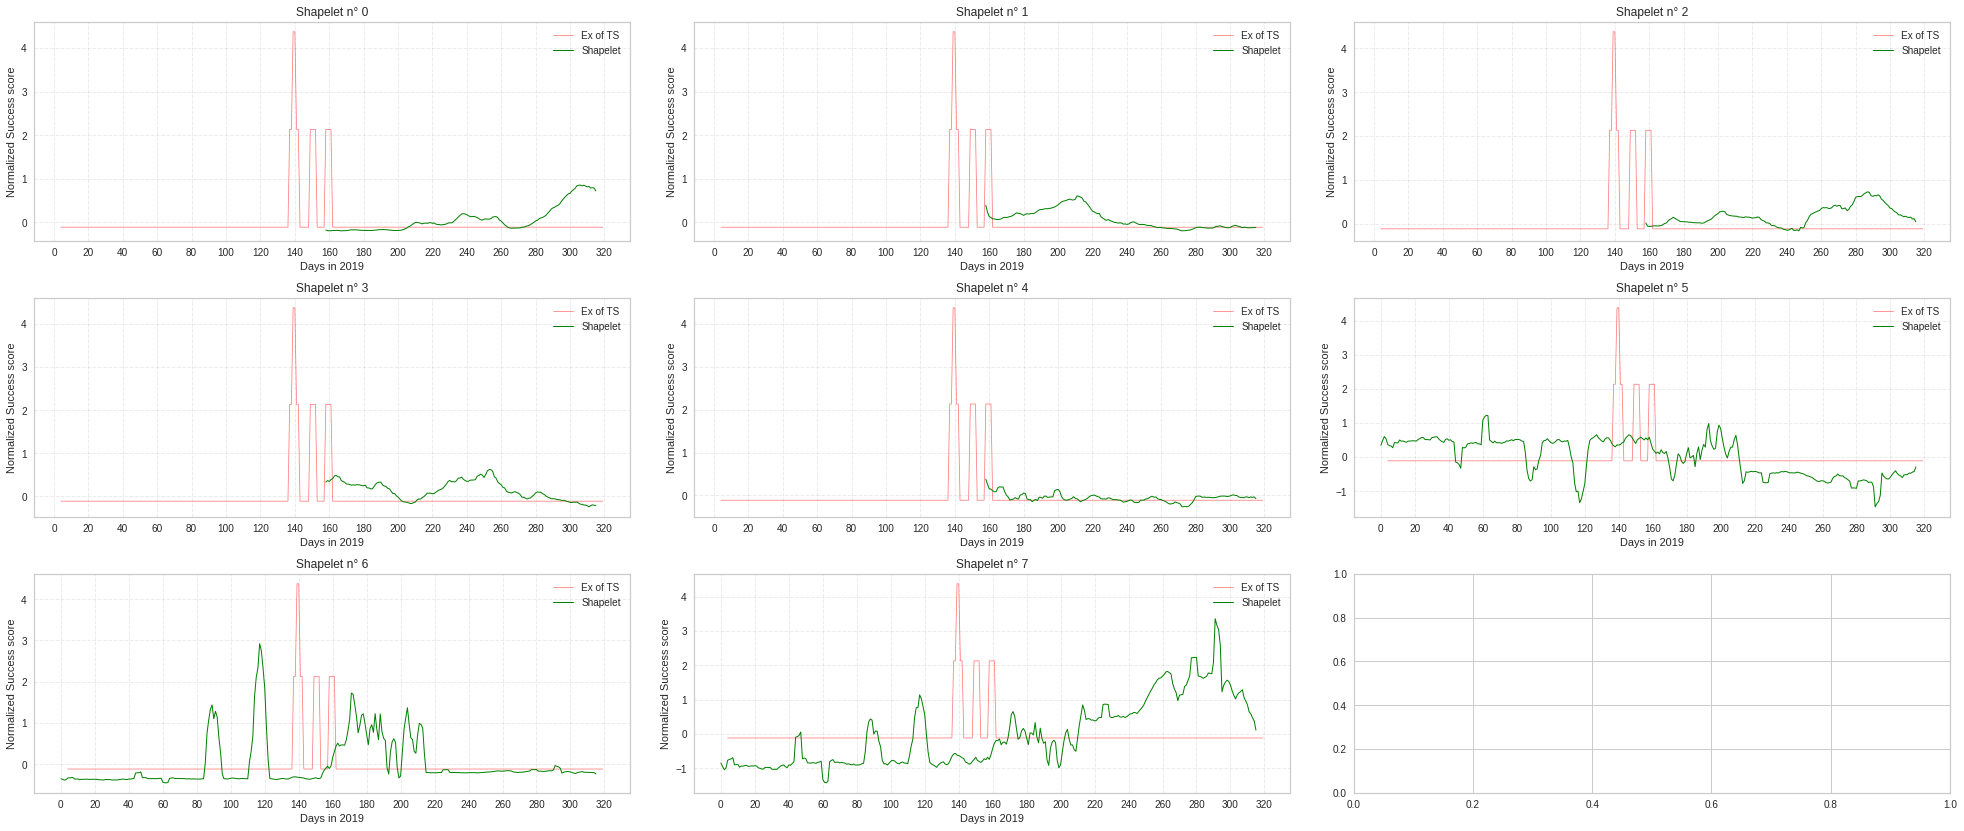

In [ ]:
# id_ts = users_std_ts_full.sample(1).index.item()
# print(id_ts)

nrows, ncols = 3, 3
id_ts = 123209387  # 1392978859

f, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(28,12))
f.tight_layout(pad=3)
for idx, shp in enumerate(shp_clf.shapelets_):
  x,y = int(idx/ncols), idx%ncols
  axs[x,y].locator_params(axis='x', nbins=30)
  axs[x,y].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.3)
  axs[x,y].set_title("Shapelet n° "+str(idx))
  axs[x,y].set_xlabel("Days in 2019")
  axs[x,y].set_ylabel("Normalized Success score")
  # axs[x,y].set_ylim(-0.5,3)
  axs[x,y].plot(users_std_ts_full.loc[id_ts][:-1],color  = "red", linewidth = 0.8,alpha=0.5,label="Ex of TS")

  t0 = predicted_locations.loc[id_ts, idx]
  axs[x,y].plot(np.arange(t0, t0 + len(shp)), shp, linewidth=1, color="green",label="Shapelet")
  axs[x,y].legend()

plt.show()